In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [2]:
# set some parameters
num_files = 1
# I recommend set num_filter to be about 10 to 20% of the original # variables
num_filter = 200
# I recommend set num_wrapper to be about 50, then look for a saturation of the model performance as variables are added
# Then you can run it again with num_wrapper just a bit above this saturation point, not more than about twice this saturation number
num_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [3]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'candidate_variables.csv'
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
    df = df[df.index <= 85264] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 3466] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','filter score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)

    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on candidate_variables.csv size is (97496, 2635)


<timed exec>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
candidate_variables.csv                     variable  filter score
1                      Fraud      1.000000
28           Cardnum_total_3      0.621932
19           Cardnum_total_1      0.619658
10           Cardnum_total_0      0.591318
15           Cardnum_count_1      0.567429
37           Cardnum_total_7      0.564245
24           Cardnum_count_3      0.563356
586         Card_dow_total_7      0.542303
17             Cardnum_max_1      0.532080
33           Cardnum_count_7      0.526897
8              Cardnum_max_0      0.525418
6            Cardnum_count_0      0.516123
595        Card_dow_total_14      0.511203
1577   Cardnum_vdratio_1by30      0.504966
1578   Cardnum_vdratio_1by60      0.502927
26             Cardnum_max_3      0.501170
46          Cardnum_total_14      0.494375
1645  Card_dow_vdratio_0by30      0.489227
1646  Card_dow_vdratio_0by60      0.48

In [4]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)

In [5]:
filter_score.head(30)

,variable,filter score
0,Fraud,1.000000
1,Cardnum_total_3,0.621932
2,Cardnum_total_1,0.619658
3,Cardnum_total_0,0.591318
4,Cardnum_count_1,0.567429
5,Cardnum_total_7,0.564245
6,Cardnum_count_3,0.563356
7,Card_dow_total_7,0.542303
8,Cardnum_max_1,0.532080
9,Cardnum_count_7,0.526897


In [6]:
filter_score.tail(10)

,variable,filter score
2625,card_merch_unique_count_for_card_state_7,0.000088
2626,Merchnum_desc_Zip_unique_count_for_Merchnum_de...,0.000075
2627,card_merch_unique_count_for_card_state_3,0.000063
2628,Merchdesc_Zip_unique_count_for_Merchdesc_State_7,0.000038
2629,Card_Merchdesc_Zip_unique_count_for_Merchdesc_...,0.000038
2630,Merchdesc_Zip_unique_count_for_Merchdesc_State_14,0.000038
2631,merch_zip_unique_count_for_merch_state_14,0.000025
2632,merch_zip_unique_count_for_merch_state_7,0.000013
2633,Merchnum_desc_Zip_unique_count_for_Merchnum_de...,0.000013
2634,card_merch_unique_count_for_Cardnum_1,0.000000


In [7]:
filter_score.shape

(2635, 2)

In [8]:
filter_score.head(80).to_csv('filter_top.csv')
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['Cardnum_total_3', 'Cardnum_total_1', 'Cardnum_total_0', 'Cardnum_count_1', 'Cardnum_total_7', 'Cardnum_count_3', 'Card_dow_total_7', 'Cardnum_max_1', 'Cardnum_count_7', 'Cardnum_max_0', 'Cardnum_count_0', 'Card_dow_total_14', 'Cardnum_vdratio_1by30', 'Cardnum_vdratio_1by60', 'Cardnum_max_3', 'Cardnum_total_14', 'Card_dow_vdratio_0by30', 'Card_dow_vdratio_0by60', 'Card_dow_max_7', 'Cardnum_vdratio_1by14', 'Cardnum_variability_max_0', 'Card_dow_count_7', 'Cardnum_actual/toal_0', 'Card_dow_vdratio_0by14', 'Cardnum_variability_max_1', 'Cardnum_unique_count_for_card_state_1', 'Cardnum_unique_count_for_card_zip_1', 'Card_dow_total_30', 'Cardnum_unique_count_for_Merchnum_1', 'Card_dow_max_14', 'Card_dow_vdratio_0by7', 'Cardnum_vdratio_1by7', 'Cardnum_unique_count_for_card_state_3', 'Cardnum_unique_count_for_card_zip_3', 'Cardnum_total_amount_1_by_60', 'Cardnum_unique_count_for_Merchnum_3', 'Cardnum_actual/toal_1', 'Card_dow_unique_count_for_merch_state_1', 'Card_dow_unique_cou

In [9]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,Cardnum_total_3,Cardnum_total_1,Cardnum_total_0,Cardnum_count_1,Cardnum_total_7,Cardnum_count_3,Card_dow_total_7,Cardnum_max_1,Cardnum_count_7,Cardnum_max_0,...,Card_dow_variability_max_30,Cardnum_unique_count_for_Merchnum_60,Card_Merchnum_desc_total_60,card_merch_max_7,Card_Merchnum_State_max_7,Card_Merchnum_Zip_max_7,card_state_max_14,Merchnum_desc_Zip_total_3,Card_Merchnum_State_total_60,card_merch_total_60
Recnum,,,,,,,,,,,,,,,,,,,,,
3466,1964.73,1551.02,333.47,3,3591.53,7,333.47,930.41,9,333.47,...,0.00,13,1960.27,983.66,983.66,983.66,983.66,854.06,1960.27,1960.27
3467,834.91,660.87,4.37,2,997.73,34,109.97,656.50,72,4.37,...,11.03,3,4.37,15.40,15.40,15.40,15.40,4.37,499.22,499.22
3468,8459.94,2904.08,271.93,7,9674.14,14,271.93,1380.45,17,271.93,...,0.00,21,2306.98,278.73,278.73,278.73,554.38,582.94,2306.98,2306.98
3469,838.53,664.49,7.99,3,1001.35,35,113.59,656.50,73,4.37,...,11.78,3,7.99,15.40,15.40,15.40,15.40,7.99,502.84,502.84
3470,16.28,16.28,16.28,1,16.28,1,16.28,16.28,1,16.28,...,0.00,1,16.28,16.28,16.28,16.28,16.28,130.15,16.28,16.28


In [10]:
df_keep.shape

(81476, 200)

In [11]:
Y.head()

,Fraud
Recnum,
3466,0
3467,0
3468,0
3469,0
3470,0


In [12]:
Y = Y.values.ravel()
Y_save = Y.copy()

In [13]:
# Y = np.array(Y)
X = df_keep
print(Y)

[0 0 0 ... 0 0 0]


In [14]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:00:56.224547


In [15]:
print(X.shape,Y.shape)

(81476, 200) (81476,)


In [16]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [17]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)

In [18]:
def fdr(classifier, x, y, cutoff=0.03):
    # Calculates FDR score for the given classifier on dataset x and y with cutoff value
    return fdr_prob(y, classifier.predict_proba(x), cutoff)

def fdr_prob(y, y_prob, cutoff=0.03):
    if len(y_prob.shape) > 1:  # Check if y_prob is multi-dimensional
        y_prob = y_prob[:, -1]  # Use the last column if it's for the positive class
    y_prob = y_prob.flatten()  # Ensure y_prob is 1D
    num_fraud = np.sum(y == 1)  # Count the total number of frauds

    # Sort the proba list from high to low while retaining the true (not predicted) fraud label
    sorted_prob = np.array(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_index = int(len(y) * cutoff)  # Calculate index for cutoff
    cutoff_bin = sorted_prob[:cutoff_index, 1]  # Get labels up to the cutoff

    # Return the FDR score (#fraud_in_cutoff / #total_fraud)
    return np.sum(cutoff_bin == 1) / num_fraud if num_fraud > 0 else 0

## Run a wrapper on the remaining top variables

In [19]:
# This is a parallel running parameter. You can try it set to -1, but sometimes the data is too large to
# be divided into that many threads and the next cell quits. A safe value is 1 for no parallelization but it 
# the runs slower. You might experiment to see how big you can set this for this data set on your machine.
njobs = 1

In [20]:
%%time
import warnings 
warnings.filterwarnings("ignore") 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get a sorted list of num_wrapper variables.

nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=10,num_leaves=3) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=2,n_jobs=njobs) # use for forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=4,n_jobs=-1) # use for backward selection
sfs.fit(X,Y)

CPU times: user 9min 22s, sys: 1min 40s, total: 11min 2s
Wall time: 5min 18s


SequentialFeatureSelector(cv=2,
                          estimator=LGBMClassifier(n_estimators=10,
                                                   num_leaves=3),
                          k_features=(20, 20),
                          scoring=<function fdr at 0x16a507ac0>)

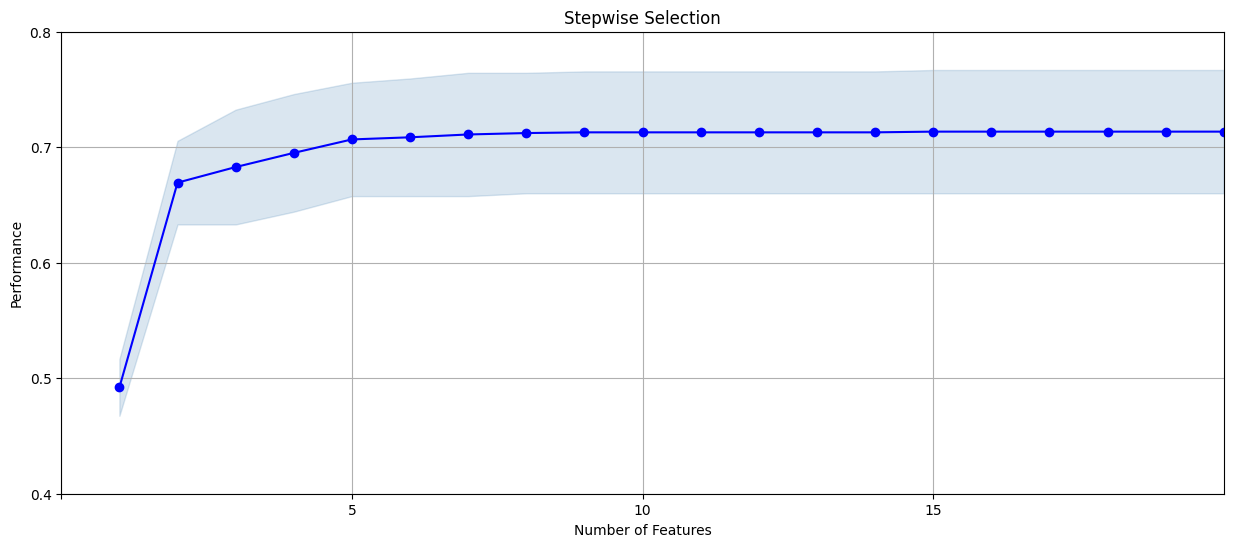

In [21]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
# plt.xticks(np.arange(0, len(X.columns), step=5))
plt.xticks(np.arange(0, num_wrapper, step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([.4,.8])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('performance_nvars.png')
plt.show()

In [22]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [23]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))[0]
# You might also need this following line. It converts a list to a string
#         ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]

In [24]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(25,)","[0.5165644171779141, 0.46748466257668714]",0.492025,"(Cardnum_unique_count_for_card_state_1,)",0.105587,0.02454,0.02454,1.0,Cardnum_unique_count_for_card_state_1
2,"(25, 129)","[0.7055214723926381, 0.6331288343558282]",0.669325,"(Cardnum_unique_count_for_card_state_1, Card_M...",0.15574,0.036196,0.036196,2.0,Card_Merchdesc_State_total_7
3,"(25, 51, 129)","[0.7325153374233129, 0.6331288343558282]",0.682822,"(Cardnum_unique_count_for_card_state_1, Cardnu...",0.213813,0.049693,0.049693,3.0,Cardnum_count_1_by_30
4,"(25, 51, 129, 151)","[0.7460122699386503, 0.6441717791411042]",0.695092,"(Cardnum_unique_count_for_card_state_1, Cardnu...",0.219092,0.05092,0.05092,4.0,Cardnum_max_14
5,"(17, 25, 51, 129, 151)","[0.7558282208588957, 0.6576687116564417]",0.706748,"(Card_dow_vdratio_0by60, Cardnum_unique_count_...",0.211173,0.04908,0.04908,5.0,Card_dow_vdratio_0by60
6,"(17, 23, 25, 51, 129, 151)","[0.7595092024539877, 0.6576687116564417]",0.708589,"(Card_dow_vdratio_0by60, Card_dow_vdratio_0by1...",0.219092,0.05092,0.05092,6.0,Card_dow_vdratio_0by14
7,"(17, 23, 25, 51, 129, 151, 185)","[0.7644171779141105, 0.6576687116564417]",0.711043,"(Card_dow_vdratio_0by60, Card_dow_vdratio_0by1...",0.229651,0.053374,0.053374,7.0,Merchnum_desc_State_total_3
8,"(17, 23, 25, 51, 129, 130, 151, 185)","[0.7644171779141105, 0.660122699386503]",0.71227,"(Card_dow_vdratio_0by60, Card_dow_vdratio_0by1...",0.224371,0.052147,0.052147,8.0,Card_Merchdesc_total_7
9,"(17, 23, 25, 51, 58, 129, 130, 151, 185)","[0.7656441717791411, 0.660122699386503]",0.712883,"(Card_dow_vdratio_0by60, Card_dow_vdratio_0by1...",0.227011,0.052761,0.052761,9.0,Card_dow_unique_count_for_merch_zip_7
10,"(17, 22, 23, 25, 51, 58, 129, 130, 151, 185)","[0.7656441717791411, 0.660122699386503]",0.712883,"(Card_dow_vdratio_0by60, Cardnum_actual/toal_0...",0.227011,0.052761,0.052761,10.0,Cardnum_actual/toal_0


In [25]:
ordered_vars_FS.to_csv('Wrapper_selection_info.csv', index=False)

In [26]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)
vars_keep

1       Cardnum_unique_count_for_card_state_1
2                Card_Merchdesc_State_total_7
3                       Cardnum_count_1_by_30
4                              Cardnum_max_14
5                      Card_dow_vdratio_0by60
6                      Card_dow_vdratio_0by14
7                 Merchnum_desc_State_total_3
8                      Card_Merchdesc_total_7
9       Card_dow_unique_count_for_merch_zip_7
10                      Cardnum_actual/toal_0
11                      Card_dow_vdratio_0by7
12                       Cardnum_vdratio_1by7
13      Cardnum_unique_count_for_card_state_3
14        Cardnum_unique_count_for_card_zip_3
15                  Merchnum_desc_Zip_total_3
16        Cardnum_unique_count_for_Merchnum_3
17                      Cardnum_actual/toal_1
18      Cardnum_unique_count_for_card_state_7
19                       Cardnum_actual/max_0
20    Card_dow_unique_count_for_merch_state_1
Name: variable name, dtype: object

In [27]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

,filter score
variable,
Cardnum_total_3,0.621932
Cardnum_total_1,0.619658
Cardnum_total_0,0.591318
Cardnum_count_1,0.567429
Cardnum_total_7,0.564245
...,...
Merchdesc_Zip_unique_count_for_Merchdesc_State_14,0.000038
merch_zip_unique_count_for_merch_state_14,0.000025
merch_zip_unique_count_for_merch_state_7,0.000013


In [28]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

""
variable
Cardnum_unique_count_for_card_state_1
Card_Merchdesc_State_total_7
Cardnum_count_1_by_30
Cardnum_max_14
Card_dow_vdratio_0by60


In [29]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')

In [30]:
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted.csv',index=False)
vars_keep_sorted

,wrapper order,variable,filter score
0,1,Cardnum_unique_count_for_card_state_1,0.476067
1,2,Card_Merchdesc_State_total_7,0.324668
2,3,Cardnum_count_1_by_30,0.428229
3,4,Cardnum_max_14,0.318826
4,5,Card_dow_vdratio_0by60,0.486480
5,6,Card_dow_vdratio_0by14,0.479086
6,7,Merchnum_desc_State_total_3,0.308586
7,8,Card_Merchdesc_total_7,0.324631
8,9,Card_dow_unique_count_for_merch_zip_7,0.418943
9,10,Cardnum_actual/toal_0,0.479550


In [31]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['Cardnum_unique_count_for_card_state_1',
 'Card_Merchdesc_State_total_7',
 'Cardnum_count_1_by_30',
 'Cardnum_max_14',
 'Card_dow_vdratio_0by60',
 'Card_dow_vdratio_0by14',
 'Merchnum_desc_State_total_3',
 'Card_Merchdesc_total_7',
 'Card_dow_unique_count_for_merch_zip_7',
 'Cardnum_actual/toal_0',
 'Card_dow_vdratio_0by7',
 'Cardnum_vdratio_1by7',
 'Cardnum_unique_count_for_card_state_3',
 'Cardnum_unique_count_for_card_zip_3',
 'Merchnum_desc_Zip_total_3',
 'Cardnum_unique_count_for_Merchnum_3',
 'Cardnum_actual/toal_1',
 'Cardnum_unique_count_for_card_state_7',
 'Cardnum_actual/max_0',
 'Card_dow_unique_count_for_merch_state_1',
 'Recnum',
 'Fraud']

In [32]:
filter_score

,filter score
variable,
Cardnum_total_3,0.621932
Cardnum_total_1,0.619658
Cardnum_total_0,0.591318
Cardnum_count_1,0.567429
Cardnum_total_7,0.564245
...,...
Merchdesc_Zip_unique_count_for_Merchdesc_State_14,0.000038
merch_zip_unique_count_for_merch_state_14,0.000025
merch_zip_unique_count_for_merch_state_7,0.000013


In [33]:
%%time
df = pd.read_csv(file_name)
df.shape

CPU times: user 16 s, sys: 1.75 s, total: 17.7 s
Wall time: 17.9 s


(97496, 2635)

In [34]:
df_keep = df.filter(vars_keep_list, axis=1)
# df_keep = df[df.index.isin(vars_keep_list)]
print(df_keep.shape)

(97496, 22)


In [35]:
df_keep.to_csv('vars_final.csv',index=False)

In [36]:
print("duration: ", dt.datetime.now() - start_time)

duration:  0:06:33.858336


In [37]:
%pwd

'/Users/stevecoggeshall/Documents/Teaching/Data sets/done/transactions'